# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn.functional as F 

from tqdm.notebook import tqdm
import utils

# Load MNIST Handwritten Dataset

In [2]:
from torchvision import datasets 
from torchvision import transforms as T

In [22]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(), 
    T.Normalize(mean=0.5, std=0.5)
])

valid_augs = T.Compose([
    T.ToTensor(),
    T.Normalize(mean = 0.5, std=0.5)
])

In [25]:
trainset = datasets.MNIST("./", download = False, train = True, transform = train_augs)
testset = datasets.MNIST("./", download = False, train = False, transform = valid_augs)

In [26]:
trainset, validset = torch.utils.data.random_split(trainset, [50000,10000])

In [27]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")
print(f"Size of testset : {len(testset)}")

Size of trainset : 50000
Size of validset : 10000
Size of testset : 10000


shape of image : torch.Size([1, 28, 28])
For visualization we need (h x w x c) so using permute shape will be : torch.Size([28, 28, 1])


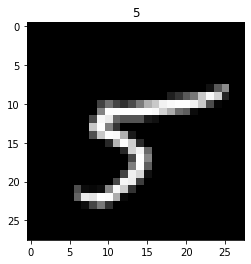

In [28]:
idx = 1
image, label = trainset[idx]

print(f'shape of image : {image.shape}')

print(f'For visualization we need (h x w x c) so using permute shape will be : {image.permute(1, 2, 0).shape}')

plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
plt.title(label);

# Load Dataset into batches

In [15]:
from torch.utils.data import DataLoader

In [29]:
bs = 64
trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)
validloader = DataLoader(validset, batch_size = bs)
testloader = DataLoader(testset, batch_size = bs)

In [30]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')
print(f'Total no. of batches in testloader : {len(testloader)}')

Total no. of batches in trainloader : 782
Total no. of batches in validloader : 157
Total no. of batches in testloader : 157


In [32]:
for images, labels in trainloader:
    print(f"One image batch shape" )

One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image 

One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image 

One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape
One image batch shape


# Load Model 

In [34]:
from models import DigitModel


model = DigitModel()
model.to("cpu")

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

# Create Train and Eval Function

In [47]:
def train_fn(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    
    for images, labels in tqdm(dataloader):
        image = images.to("cpu")
        labels = labels.to("cpu")
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc+= utils.multiclass_accuracy(logits, labels)
        
    return total_loss/len(dataloader), total_acc /len(dataloader)
        

In [53]:
def eval_fn(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    
    with torch.no_grad():
    
        for images, labels in tqdm(dataloader):
            image = images.to("cpu")
            labels = labels.to("cpu")


            logits = model(images)
            loss = criterion(logits, labels)



            total_loss += loss.item()
            total_acc+= utils.multiclass_accuracy(logits, labels)
        
        return total_loss/len(dataloader), total_acc /len(dataloader)

# Training Loop 

In [44]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

In [54]:
best_valid_loss = np.Inf

for i in range(7):
    train_loss, train_acc = train_fn(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc =eval_fn(model, trainloader, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_weights.pt")
        best_valid_loss = valid_loss

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

# Inference

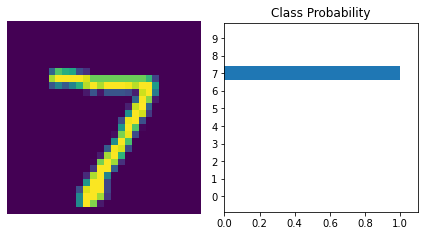

In [55]:
image, label = testset[0]
weights = torch.load("best_weights.pt")

model.load_state_dict(weights)


model.eval()
with torch.no_grad():
    logits = model(image.unsqueeze(0))
    ps = torch.nn.Softmax(dim=1)(logits)[0]
    
    utils.view_classify(image,ps)